# Working Notebook 1

# Imports

In [225]:
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LassoLars, TweedieRegressor

import env

# Acquire data

In [80]:
def get_zillow_data():
        ''' Acquire Zillow data using properties_2017 table from Code up Data Base. Columns bedroomcnt, 
            bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips 
        '''
   
         # sql query for acquisition
        sql_query = """
        SELECT calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,taxvaluedollarcnt

        FROM properties_2017
        LEFT JOIN propertylandusetype USING(propertylandusetypeid)
        LEFT JOIN predictions_2017 USING(parcelid)
        WHERE (propertylandusetype.propertylandusedesc LIKE ("%%Single%%")) 
            AND (predictions_2017.transactiondate like "2017%%");
        """
        # Acquisition
        df = pd.read_sql(sql_query, env.get_connection('zillow'))
        return df

In [78]:
# had to adress % by using %% so it could be read by notebook

In [81]:
# import data
df = get_zillow_data()

In [82]:
# 52441 observations
df.shape

(52441, 4)

In [83]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   calculatedfinishedsquarefeet  52359 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   bedroomcnt                    52441 non-null  float64
 3   taxvaluedollarcnt             52440 non-null  float64
dtypes: float64(4)
memory usage: 1.6 MB


<div class="alert alert-info"> There seems to be nulls in calculatedfiniched square feet

In [84]:
df.isnull().sum()

calculatedfinishedsquarefeet    82
bathroomcnt                      0
bedroomcnt                       0
taxvaluedollarcnt                1
dtype: int64

<div class="alert alert-info"> There are 82 nulls in calculatedfinishedsquarefeet and one in taxvalluedollarcnt I could drop them or try to fill in with mean or median value.

In [87]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
squarefeet,52359.0,1922.890754,1004.365838,128.0,1268.0,1659.0,2306.00,21929.0
bathrooms,52441.0,2.299403,1.022772,0.0,2.0,2.0,3.00,18.0
bedrooms,52441.0,3.300681,0.949094,0.0,3.0,3.0,4.00,14.0
tax_value,52440.0,529688.163921,751894.553363,1000.0,193747.5,373612.0,619301.25,49061236.0


<div class="alert alert-info"> There seems to be bathrooms/ bedrooms with min of 0 and max above what ight be consider a single family dweling

In [88]:
# rename columns
df = df.rename(columns={'bedroomcnt': 'bedrooms','bathroomcnt': 'bathrooms',
            'calculatedfinishedsquarefeet': 'squarefeet','taxvaluedollarcnt': 'tax_value'})

In [89]:
df = df.dropna()

In [90]:
df= df[~(df.bathrooms==0) & ~(df.bedrooms ==0)]

In [91]:
def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathrooms <= 5.5]
    
    df = df[df.bedrooms<= 6]
    
    return df


In [92]:
df = handle_outliers(df)
df

,squarefeet,bathrooms,bedrooms,tax_value
0,1788.0,2.0,4.0,112973.0
1,3054.0,5.0,6.0,416251.0
2,1214.0,2.0,3.0,1827450.0
3,1926.0,2.0,3.0,239251.0
4,2448.0,2.0,4.0,480382.0
...,...,...,...,...
52436,1193.0,1.0,3.0,87686.0
52437,1719.0,2.5,3.0,464276.0
52438,1466.0,1.0,2.0,81167.0
52439,726.0,1.0,2.0,137268.0


# split data for exploration

In [93]:
def split_data(df):
    '''
    split_data takes in data Frame and splits into  train , validate, test.
    The split is 20% test 80% train/validate. Then 30% of 80% validate and 70% of 80% train.
    Aproximately (train 56%, validate 24%, test 20%)
    Returns train, validate, and test 
    '''
    # split test data from train/validate
    train_and_validate, test = train_test_split(df, random_state=123, test_size=.2)

    # split train from validate
    train, validate = train_test_split(train_and_validate, random_state=123, test_size=.3)
                                   
    return train, validate, test

In [94]:
train, validate, test = split_data(df)

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28922 entries, 6813 to 1606
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   squarefeet  28922 non-null  float64
 1   bathrooms   28922 non-null  float64
 2   bedrooms    28922 non-null  float64
 3   tax_value   28922 non-null  float64
dtypes: float64(4)
memory usage: 1.1 MB


In [96]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
squarefeet,28922.0,1874.470265,864.287137,152.0,1260.0,1647.0,2283.75,8305.0
bathrooms,28922.0,2.256085,0.912468,1.0,2.0,2.0,3.00,5.5
bedrooms,28922.0,3.280548,0.894095,1.0,3.0,3.0,4.00,6.0
tax_value,28922.0,497602.206625,563179.499456,3254.0,192165.5,369853.5,607845.25,15618488.0


In [97]:
train.head()

,squarefeet,bathrooms,bedrooms,tax_value
6813,1618.0,2.0,2.0,412018.0
41016,1236.0,2.0,4.0,434923.0
50907,1866.0,2.5,4.0,307895.0
34211,624.0,1.0,1.0,225000.0
16927,1143.0,2.0,3.0,56691.0


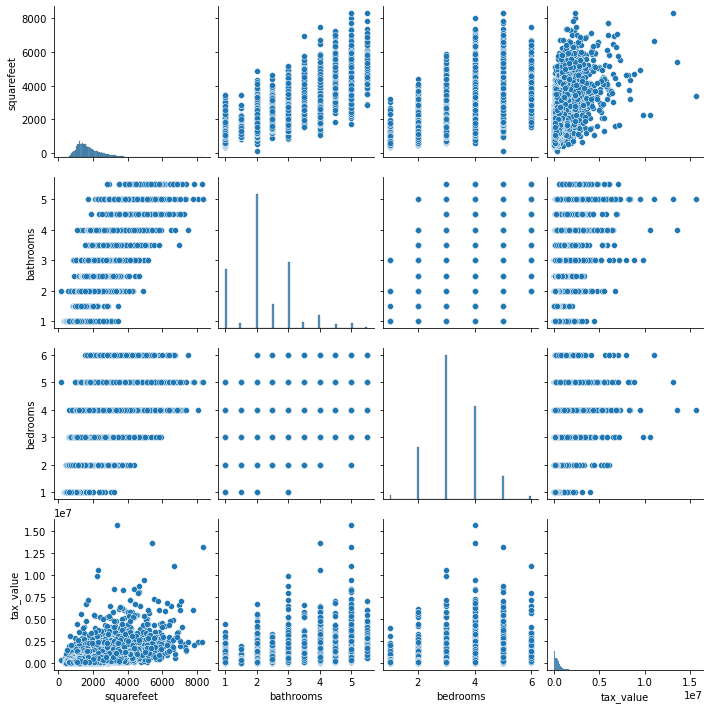

In [98]:
sns.pairplot(train)

In [99]:
# correaltion between variables
zillow_corr = train.corr(method='spearman')
zillow_corr

,squarefeet,bathrooms,bedrooms,tax_value
squarefeet,1.000000,0.833684,0.662777,0.515967
bathrooms,0.833684,1.000000,0.626727,0.478538
bedrooms,0.662777,0.626727,1.000000,0.284940
tax_value,0.515967,0.478538,0.284940,1.000000


<AxesSubplot:>

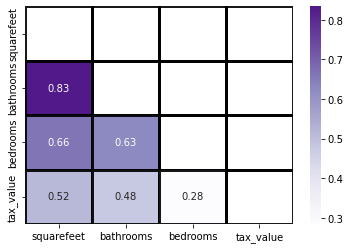

In [100]:
# pass my correlation matrix to Seaborn's heatmap 
kwargs = {'alpha':.9,
          'linewidth':3, 
          'linestyle':'-',
          'linecolor':'black'}
sns.heatmap(zillow_corr, cmap='Purples', annot=True, 
            mask=np.triu(zillow_corr), **kwargs)

In [101]:
def plot_variable_pair(df):
    columns = ['bedrooms',
 'bathrooms',
 'squarefeet']
    for i, col in enumerate(columns):
        sns.lmplot(data=df, x=col, y='tax_value', line_kws={'color':'red'})
        plt.show()

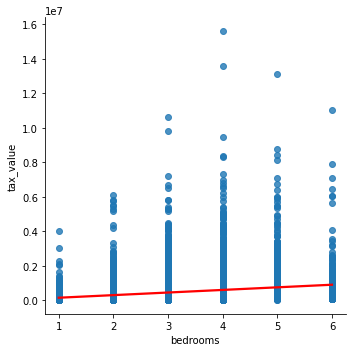

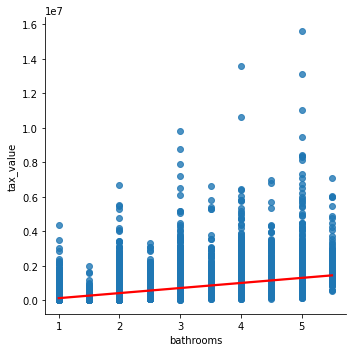

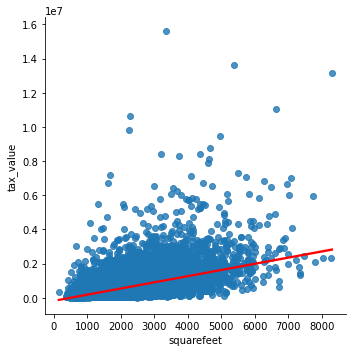

In [102]:
plot_variable_pair(train)

In [103]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()

In [121]:
# set categories
cat_vars =['bathrooms','bedrooms']
cont_vars =['tax_value','squarefeet']

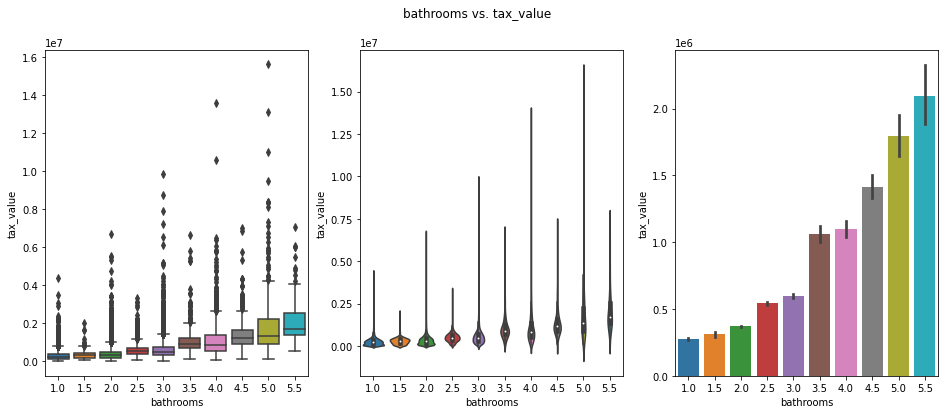

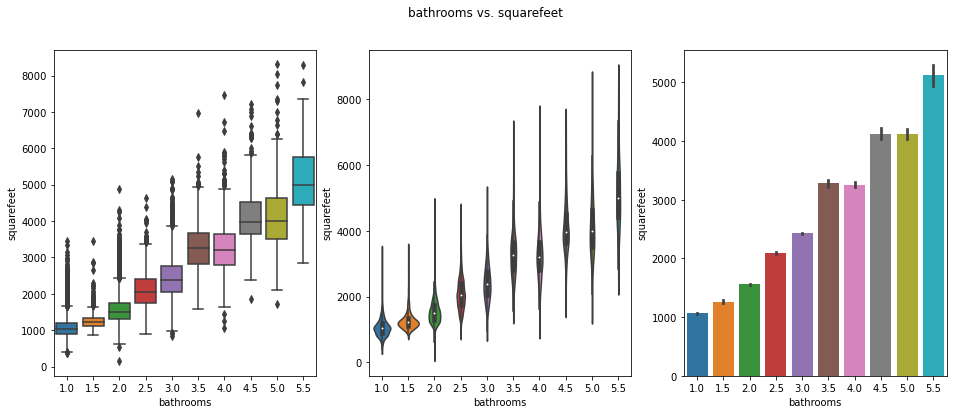

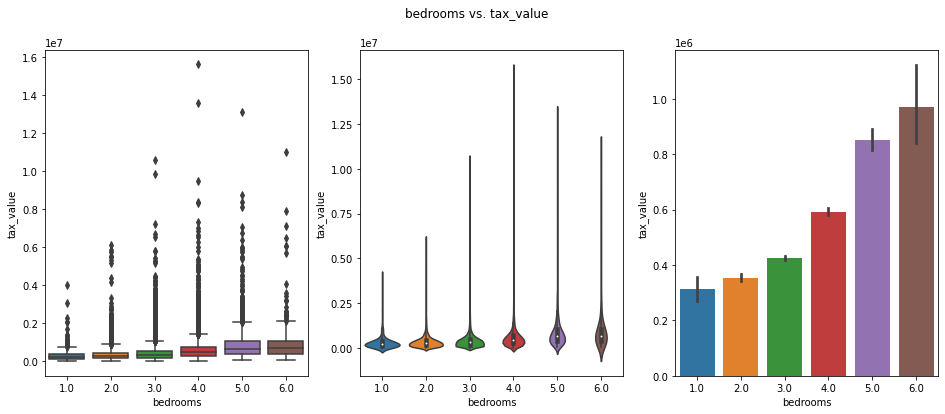

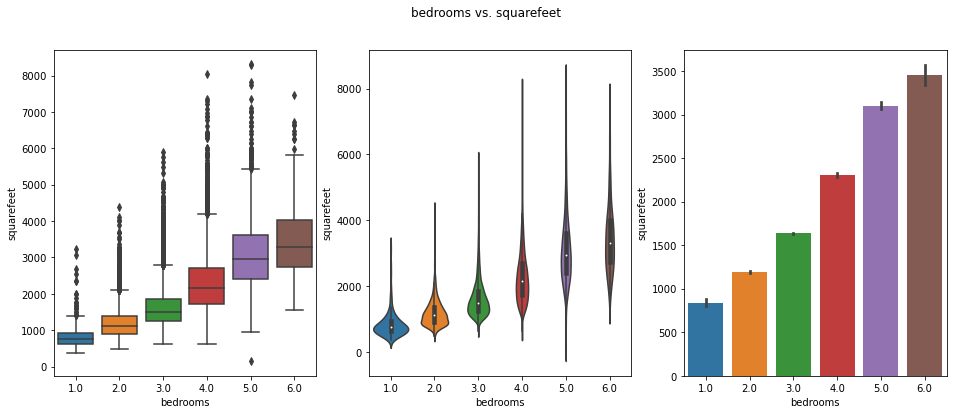

In [122]:
plot_categorical_and_continuous_vars(train, cat_vars, cont_vars)

In [123]:
def show_cat_vs_cont(df, cat_vars=cat_vars, cont_vars=cont_vars):
    print('Categorical vs Continuous Variables:')
    #number = 1
    palettes = ['flare', 'Blues_r', 'PuRd_r', 'Accent']
    for j, cont in enumerate(cont_vars):
        plt.figure(figsize=(20,4))
        plt.suptitle(cont)
        for i, cat in enumerate(cat_vars):
            plt.subplot(1, 4, i+1)
            sns.barplot(data=df, x=cat, y=cont, palette=palettes[j])
            plt.title(cat + ' vs ' + cont)
        plt.show()

Categorical vs Continuous Variables:


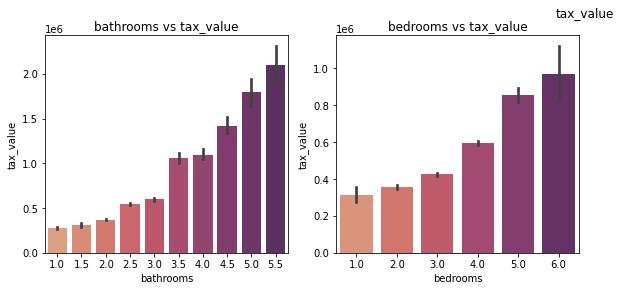

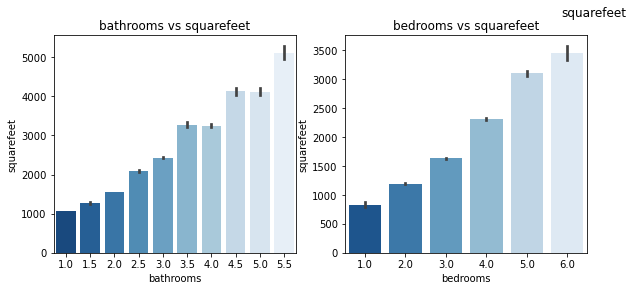

In [124]:
show_cat_vs_cont(train, cat_vars,cont_vars)

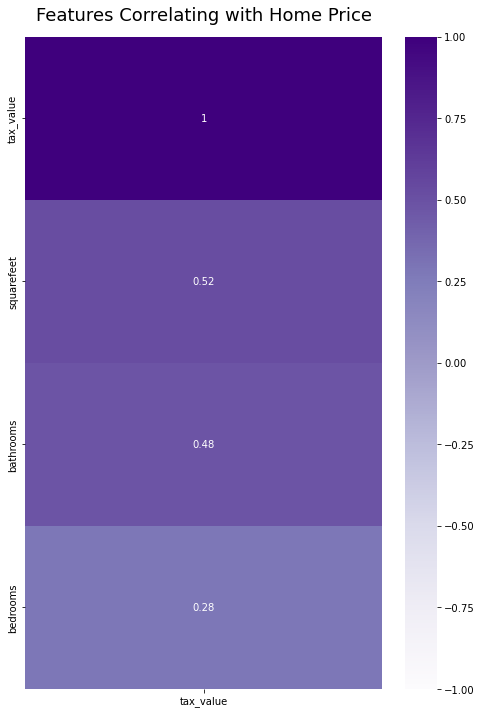

In [125]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr(method='spearman')[['tax_value']].sort_values(by='tax_value', ascending=False), vmin=-1, vmax=1, annot=True, cmap='Purples')
heatmap.set_title('Features Correlating with Home Price', fontdict={'fontsize':18}, pad=16);

<AxesSubplot:xlabel='bathrooms', ylabel='count'>

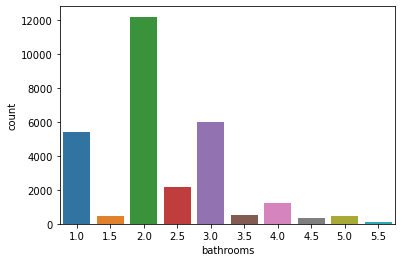

In [134]:
sns.countplot(x='bathrooms', data=train)

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

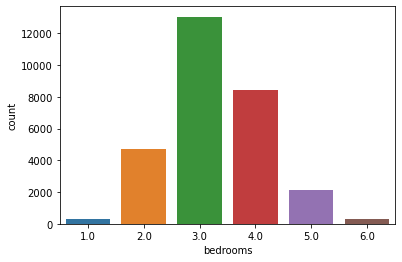

In [135]:
sns.countplot(x='bedrooms', data=train)

# Stats

In [126]:
above_mean_bathrooms = train.bathrooms[train.bathrooms > train.bathrooms.mean()]
overall_mean = train.bathrooms.mean()

In [127]:
alpha=0.05
t, p = stats.ttest_1samp(above_mean_bathrooms, overall_mean)

print(t, p/2)

147.09547864648172 0.0


In [132]:
# pearsonr r for continuous variables
for i in cont_vars:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.tax_value)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between tax_value in different {i}')
    print(f'Ha:(There is a significant difference between tax_value in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between tax_value and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between tax_value and {i}')

_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between tax_value in different tax_value
Ha:(There is a significant difference between tax_value in different tax_value
tax_value correlation 0.9999999999999973, p-val0.0
We reject the null hypothesis.
There is a correlation between tax_value and tax_value
_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between tax_value in different squarefeet
Ha:(There is a significant difference between tax_value in different squarefeet
squarefeet correlation 0.5543698771789676, p-val0.0
We reject the null hypothesis.
There is a correlation between tax_value and squarefeet


In [133]:
for i in cat_vars:
    α =0.05
    corr, p = stats.pearsonr(train[i], train.tax_value)
    print('_____________________________________________________')
    print('HYPOTHESIS')
    print(f'H0: There is no significant difference between tax_value in different {i}')
    print(f'Ha:(There is a significant difference between tax_value in different {i}')
    print(f'{i} correlation {corr}, p-val{p}')
    if p < α:
        print('We reject the null hypothesis.')
        print(f'There is a correlation between tax_value and {i}')
    else:
        print('We fail to reject the null hypothesis.')
        print(f'There is no correlation between tax_value and {i}')

_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between tax_value in different bathrooms
Ha:(There is a significant difference between tax_value in different bathrooms
bathrooms correlation 0.4755068971071995, p-val0.0
We reject the null hypothesis.
There is a correlation between tax_value and bathrooms
_____________________________________________________
HYPOTHESIS
H0: There is no significant difference between tax_value in different bedrooms
Ha:(There is a significant difference between tax_value in different bedrooms
bedrooms correlation 0.2392011790565752, p-val0.0
We reject the null hypothesis.
There is a correlation between tax_value and bedrooms


# Model

### Scale Data

In [237]:
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['bedrooms', 'bathrooms', 'squarefeet']):
    '''
    scale_data takes in train , validate, test data  and returns their scaled counterparts.
    '''
    # create copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    #create the scaler
    scaler = QuantileTransformer(output_distribution='normal')
    # fit the scaler into train data
    scaler.fit(train[columns_to_scale])
    
    # applying the scaler to train, validate, and test data
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled

In [238]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(train,validate,test)

In [239]:

# Setup X and y
X_train_scaled = X_train_scaled.drop(columns='tax_value')
y_train = train.tax_value

X_validate_scaled = X_validate_scaled.drop(columns='tax_value')
y_validate = validate.tax_value

X_test_scaled = X_test_scaled.drop(columns='tax_value')
y_test = test.tax_value

In [240]:
# Turn everything into a dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

### Select Features for model

In [241]:
def select_Kbest(X, y, k=2):   
    '''
    select_Kbest takes in :
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of features
    
    returns: a list of the selected features using SelectBest 
    '''
    # model
    kbest = SelectKBest(f_regression, k=k)
    # fit
    kbest.fit(X, y)
    # mask of selection
    feature_mask = kbest.get_support()
    rank = X.columns[feature_mask]
    
    # convert to list
    rank = rank.to_list()


    return f'TOP {k} features: {rank}'

In [242]:
select_Kbest(X_train_scaled,y_train, k=2)

"TOP 2 features: ['squarefeet', 'bathrooms']"

### Simple model

In [243]:
predictions = pd.DataFrame({
    'actual': validate.tax_value
}) 

In [244]:
# X must be 2-d array
#X_train_scaled = X_train_scaled[['bathrooms']]
# y can be 1-d array
#y_train = train.tax_value

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train_scaled[['bathrooms']], y_train)
# 3. use the thing (make predictions)
#X_validate = validate[['taxamount']]
predictions['simple_lm'] = lm.predict(X_validate[['bathrooms']])

In [245]:
# look into modesl make up 
lm.coef_, lm.intercept_

(array([78884.35411346]), 552182.3291759454)

In [246]:
print(f'tax_value = {lm.coef_}*bathrooms + {lm.intercept_}')

tax_value = [78884.35411346]*bathrooms + 552182.3291759454


In [247]:
predictions

,actual,simple_lm
21619,"207,835.000","670,508.860"
21052,"171,656.000","788,835.392"
50980,"609,150.000","709,951.037"
4359,"656,000.000","788,835.392"
36190,"515,696.000","709,951.037"
...,...,...
41577,"1,700,543.000","788,835.392"
36765,"1,623,391.000","828,277.569"
50087,"465,466.000","788,835.392"
23800,"790,000.000","788,835.392"


### Multiple + RFE

In [248]:
def rfe(X, y, k=2):
    ''' 
    rfe takes in:
    X: a dataframe representing numerical independent features
    y: a pandas Series representing a target variable
    k: a keyword argument defaulted to 2 for the number of features
    
    returns: a list of the selected features using RFE
    '''
    # Model
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select= k)
    #fit
    rfe.fit(X, y)
    # mask selection
    mask = rfe.get_support()
    
    return X.columns[mask]

In [249]:
rfe(X_train_scaled, y_train, k=2)

Index(['squarefeet', 'bedrooms'], dtype='object')

In [252]:


lm = LinearRegression()
k = 2

### 1. Transform our X
rfe = RFE(lm, n_features_to_select=2)
rfe.fit(X_train_scaled, y_train)
print('selected top 2 features:', X_train_scaled.columns[rfe.support_])
X_train_rfe = rfe.transform(X_train_scaled)

selected top 2 features: Index(['squarefeet', 'bedrooms'], dtype='object')


In [253]:
# 1. Transform our X
X_train_rfe = rfe.transform(X_train_scaled)
# 2. Use the transformed x in our model
lm.fit(X_train_rfe, y_train)

# 3. Make predictions
X_validate_rfe = rfe.transform(X_validate)
predictions['multiple_rfe'] = lm.predict(X_validate_rfe)

predictions.head()

,actual,simple_lm,multiple_rfe
21619,"207,835.000","670,508.860","573,281,111.787"
21052,"171,656.000","788,835.392","725,039,406.455"
50980,"609,150.000","709,951.037","466,992,981.286"
4359,"656,000.000","788,835.392","829,809,777.252"
36190,"515,696.000","709,951.037","396,828,581.450"


In [254]:
# look into models make up
lm.coef_, lm.intercept_

(array([317485.97211022, -69670.15670327]), 497612.7544168949)

In [255]:
print(f'tax_value = {lm.coef_[0]:.2f} x squarefeet + {lm.coef_[1]:.2f} x bedroom + {lm.intercept_:.2f}')

tax_value = 317485.97 x squarefeet + -69670.16 x bedroom + 497612.75


### Poly Degree2

In [256]:
# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_train_scaled)
X_train_poly = pd.DataFrame(
    poly.transform(X_train_scaled),
    columns=poly.get_feature_names(X_train_scaled.columns),
    index=train.index,
)
X_train_poly.head()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,squarefeet,bathrooms,bedrooms,squarefeet^2,squarefeet bathrooms,squarefeet bedrooms,bathrooms^2,bathrooms bedrooms,bedrooms^2
6813,-0.044,-0.219,-1.325,0.002,0.010,0.058,0.048,0.290,1.756
41016,-0.738,-0.219,0.745,0.545,0.161,-0.550,0.048,-0.163,0.555
50907,0.267,0.417,0.745,0.071,0.111,0.199,0.174,0.311,0.555
34211,-2.575,-5.199,-5.199,6.633,13.391,13.391,27.033,27.033,27.033
16927,-0.965,-0.219,-0.252,0.932,0.211,0.244,0.048,0.055,0.064


In [257]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate_scaled)
predictions['polynomial degree 2'] = lm.predict(X_validate_poly)
predictions

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,actual,simple_lm,multiple_rfe,polynomial degree 2
21619,"207,835.000","670,508.860","573,281,111.787","316,077.807"
21052,"171,656.000","788,835.392","725,039,406.455","593,995.910"
50980,"609,150.000","709,951.037","466,992,981.286","306,494.603"
4359,"656,000.000","788,835.392","829,809,777.252","717,811.146"
36190,"515,696.000","709,951.037","396,828,581.450","262,905.479"
...,...,...,...,...
41577,"1,700,543.000","788,835.392","910,838,370.296","932,315.905"
36765,"1,623,391.000","828,277.569","1,590,506,166.428","1,791,828.274"
50087,"465,466.000","788,835.392","864,415,748.212","757,656.988"
23800,"790,000.000","788,835.392","761,550,293.248","634,796.316"


# Poly interactions_only 

In [258]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X_train_scaled)
X_train_poly = pd.DataFrame(
    poly.transform(X_train),
    columns=poly.get_feature_names(X_train.columns),
    index=train.index,
)
lm = LinearRegression()
lm.fit(X_train_poly, y_train)

X_validate_poly = poly.transform(X_validate_scaled)
predictions['polynomial only interaction'] = lm.predict(X_validate_poly)

pd.Series(lm.coef_, index=poly.get_feature_names(X_train_scaled.columns)).sort_values()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


bathrooms bedrooms     -52,582.859
squarefeet bedrooms         -2.844
squarefeet                  19.449
squarefeet bathrooms       114.117
bathrooms               31,164.667
bedrooms                37,162.127
dtype: float64

In [259]:
predictions

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction
21619,"207,835.000","670,508.860","573,281,111.787","316,077.807","180,867.466"
21052,"171,656.000","788,835.392","725,039,406.455","593,995.910","167,272.454"
50980,"609,150.000","709,951.037","466,992,981.286","306,494.603","127,233.146"
4359,"656,000.000","788,835.392","829,809,777.252","717,811.146","167,305.063"
36190,"515,696.000","709,951.037","396,828,581.450","262,905.479","127,235.186"
...,...,...,...,...,...
41577,"1,700,543.000","788,835.392","910,838,370.296","932,315.905","174,929.445"
36765,"1,623,391.000","828,277.569","1,590,506,166.428","1,791,828.274","163,414.370"
50087,"465,466.000","788,835.392","864,415,748.212","757,656.988","167,314.413"
23800,"790,000.000","788,835.392","761,550,293.248","634,796.316","167,283.906"


## Laso Lars

In [260]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data
lars.fit(X_train, y_train)

# predict validate
X_validate_pred_lars = lars.predict(X_validate)

# Add lassolars predictions to our predictions DataFrame
predictions['lasso_lars'] = X_validate_pred_lars

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [261]:
predictions

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars
21619,"207,835.000","670,508.860","573,281,111.787","316,077.807","180,867.466","329,134.487"
21052,"171,656.000","788,835.392","725,039,406.455","593,995.910","167,272.454","615,295.580"
50980,"609,150.000","709,951.037","466,992,981.286","306,494.603","127,233.146","360,748.390"
4359,"656,000.000","788,835.392","829,809,777.252","717,811.146","167,305.063","740,909.595"
36190,"515,696.000","709,951.037","396,828,581.450","262,905.479","127,235.186","276,625.064"
...,...,...,...,...,...,...
41577,"1,700,543.000","788,835.392","910,838,370.296","932,315.905","174,929.445","962,369.101"
36765,"1,623,391.000","828,277.569","1,590,506,166.428","1,791,828.274","163,414.370","1,687,680.511"
50087,"465,466.000","788,835.392","864,415,748.212","757,656.988","167,314.413","782,400.286"
23800,"790,000.000","788,835.392","761,550,293.248","634,796.316","167,283.906","659,070.161"


# GLM

In [262]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train_scaled, y_train)

# predict validate
X_validate_predict_glm = glm.predict(X_validate_scaled)

# Add lassolars predictions to our predictions DataFrame
predictions['glm'] = X_validate_predict_glm

### Baseline

In [263]:
# add a baseline model
predictions['baseline'] = train.tax_value.mean()

In [264]:
predictions

,actual,simple_lm,multiple_rfe,polynomial degree 2,polynomial only interaction,lasso_lars,glm,baseline
21619,"207,835.000","670,508.860","573,281,111.787","316,077.807","180,867.466","329,134.487","444,406.380","497,602.207"
21052,"171,656.000","788,835.392","725,039,406.455","593,995.910","167,272.454","615,295.580","597,101.190","497,602.207"
50980,"609,150.000","709,951.037","466,992,981.286","306,494.603","127,233.146","360,748.390","374,613.443","497,602.207"
4359,"656,000.000","788,835.392","829,809,777.252","717,811.146","167,305.063","740,909.595","709,175.393","497,602.207"
36190,"515,696.000","709,951.037","396,828,581.450","262,905.479","127,235.186","276,625.064","289,784.730","497,602.207"
...,...,...,...,...,...,...,...,...
41577,"1,700,543.000","788,835.392","910,838,370.296","932,315.905","174,929.445","962,369.101","893,179.714","497,602.207"
36765,"1,623,391.000","828,277.569","1,590,506,166.428","1,791,828.274","163,414.370","1,687,680.511","1,746,264.157","497,602.207"
50087,"465,466.000","788,835.392","864,415,748.212","757,656.988","167,314.413","782,400.286","745,029.945","497,602.207"
23800,"790,000.000","788,835.392","761,550,293.248","634,796.316","167,283.906","659,070.161","634,285.097","497,602.207"


# Evaluate

In [265]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

actual                                              0.000
polynomial degree 2                   202,325,034,009.401
glm                                   204,628,627,087.153
lasso_lars                            205,881,516,805.602
baseline                              309,062,184,941.573
simple_lm                             331,639,969,340.622
polynomial only interaction           532,133,789,977.674
multiple_rfe                  429,966,899,414,687,168.000
dtype: float64

In [266]:
pd.options.display.float_format = '{:,.3f}'.format
def calculate_RMSE(y_predicted):
    return mean_squared_error(predictions.acual,y_predicted)
predictions.apply(calculate_mse).sort_values()**.5

actual                                  0.000
polynomial degree 2               449,805.551
glm                               452,358.958
lasso_lars                        453,741.685
baseline                          555,933.616
simple_lm                         575,881.906
polynomial only interaction       729,475.010
multiple_rfe                  655,718,612.985
dtype: float64

First itteration of models Polynomial degree2 was best, Then glm, then lasso_lars then baseline